# 04 RNA velocity

## Notebook setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
from collections import Counter
import matplotlib.font_manager
import openpyxl
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#import magic
#import seaborn as sns
import palantir
import loompy
import feather
import re
#from scipy.sparse import csgraph

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)
import matplotlib.lines as lines

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.5.3 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
user_defined_palette =  [ '#F6222E', '#FEAF16','#3283FE','#BDCDFF', '#3B00FB', '#F8A19F', '#1CFFCE',  '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F','#B5EFB5', '#0e452b', '#AA0DFE']

In [3]:
user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

In [4]:
%matplotlib inline 

## Load Fig 1a data

In [5]:
path_to_h5ad = '../output/anndata_io/Fig1af.h5ad'

In [6]:
#adata_d0.write(path_to_h5ad)

In [7]:
adata_d0 = sc.read_h5ad(path_to_h5ad)
adata_d0.uns['log1p']["base"] = None

In [8]:
adata_d0.shape

(22932, 27657)

## Include looms

In [9]:
import scvelo as scv
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True, format='pdf')

In [10]:
from pathlib import Path

ds_list = []

loom_path = ['../data/internal/10xGenomics/Chromium/LJ078/LJ078-Baseline_1_1/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ078/ECs/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ078/LJ078-Baseline_1_2/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ078/FBs/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ129/LJ129_Baseline_CD45negative_b1/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ129/LJ129_Baseline_CD45negative_b2/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ129/LJ129_Baseline_EC/cr-results/velocyto/cr-results.loom',
             '../data/internal/10xGenomics/Chromium/LJ129/LJ129_Baseline_FB/cr-results/velocyto/cr-results.loom'      
            ]

with loompy.new('loom_merged_d0.loom') as dsout:  # Create a new, empty, loom file
    for f in loom_path:
        with loompy.connect(f) as ds:
            totals = ds.map([np.sum], axis=1)[0]
            cells = np.where(totals > 0)[0] # Select the cells that passed QC (totals > 500)
            ds_list.append(ds.shape[1])
            for (ix, selection, view) in ds.scan(items=cells, axis=1):
                dsout.add_columns(view.layers, col_attrs=view.ca, row_attrs=view.ra)

In [11]:
ldata = scv.read('loom_merged_d0.loom')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [12]:
x = np.repeat(np.array([ '-1@mo02_CD45neg1_d0', '-1@mo02_EC_d0', '-1@mo02_CD45neg2_d0', '-1@mo02_FB_d0',
                         '-1@mo18_CD45neg1_d0', '-1@mo18_CD45neg2_d0', '-1@mo18_EC_d0', '-1@mo18_FB_d0']), ds_list, axis=0)

In [13]:
ldata.obs['name_match'] = x

In [14]:
start = ':'
end = 'x'

barcodes = []
for loom_index in ldata.obs_names:
    barcodes.append(str(loom_index[loom_index.find(start)+len(start):loom_index.rfind(end)]))
ldata.obs['barcodes'] = barcodes

In [15]:
ldata.obs_names = ldata.obs[['barcodes','name_match']].agg(''.join, axis=1)

In [16]:
from collections import Counter
[k for k, v in Counter(ldata.obs_names).items() if v > 1]

[]

In [17]:
adata_d0_loom = scv.utils.merge(adata_d0, ldata)

In [18]:
adata_d0_loom.shape

(22932, 27657)

### Only TECs - both stages - all

In [19]:
TEC_d0_loom = adata_d0_loom[((adata_d0_loom.obs['cell_type_subset']=='10:aaTEC1') | (adata_d0_loom.obs['cell_type_subset']=='11:aaTEC2') | (adata_d0_loom.obs['cell_type_subset']=='12:cTEC') |
                      (adata_d0_loom.obs['cell_type_subset']=='13:mTEC1') | (adata_d0_loom.obs['cell_type_subset']=='14:mTEC-prol') | (adata_d0_loom.obs['cell_type_subset']=='15:mTEC2') |
                      (adata_d0_loom.obs['cell_type_subset']=='16:mimetic(basal)') | (adata_d0_loom.obs['cell_type_subset']=='17:mimetic(tuft)') | (adata_d0_loom.obs['cell_type_subset']=='18:mimetic(neuroendo)') |
                      (adata_d0_loom.obs['cell_type_subset']=='19:mimetic(goblet)') | (adata_d0_loom.obs['cell_type_subset']=='20:mimetic(microfold)') | (adata_d0_loom.obs['cell_type_subset']=='12:early Pr') )] 

In [20]:
# Remove columns with all 0s
sc.pp.filter_genes(TEC_d0_loom, min_cells=1)

filtered out 651 genes that are detected in less than 1 cells


In [21]:
sc.pp.highly_variable_genes(TEC_d0_loom, n_top_genes=3500, n_bins=20, flavor='seurat')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [22]:
rng = np.random.RandomState(42)
sc.tl.pca(TEC_d0_loom, n_comps=50, svd_solver='arpack', random_state=rng, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [23]:
sce.pp.harmony_integrate(TEC_d0_loom, 'sample')

2024-04-16 12:33:53,824 - harmonypy - INFO - Iteration 1 of 10
2024-04-16 12:33:54,602 - harmonypy - INFO - Iteration 2 of 10
2024-04-16 12:33:55,343 - harmonypy - INFO - Iteration 3 of 10
2024-04-16 12:33:56,080 - harmonypy - INFO - Iteration 4 of 10
2024-04-16 12:33:56,598 - harmonypy - INFO - Converged after 4 iterations


In [24]:
sc.pp.neighbors(TEC_d0_loom, n_neighbors=15, use_rep='X_pca_harmony')
sc.tl.umap(TEC_d0_loom)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [25]:
TEC_d0_loom.shape

(6175, 27006)

In [26]:
scv.tl.velocity(TEC_d0_loom, mode='stochastic')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [27]:
scv.tl.velocity_graph(TEC_d0_loom, n_jobs=7)

computing velocity graph (using 7/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


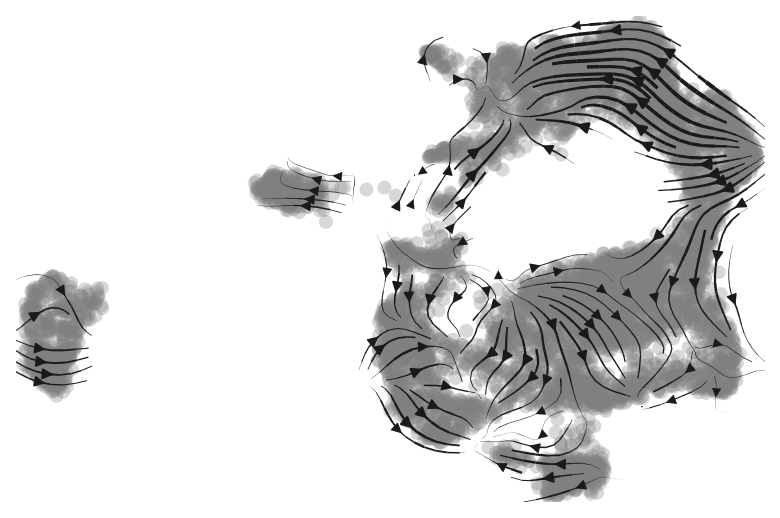

In [28]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0_loom, basis='umap')

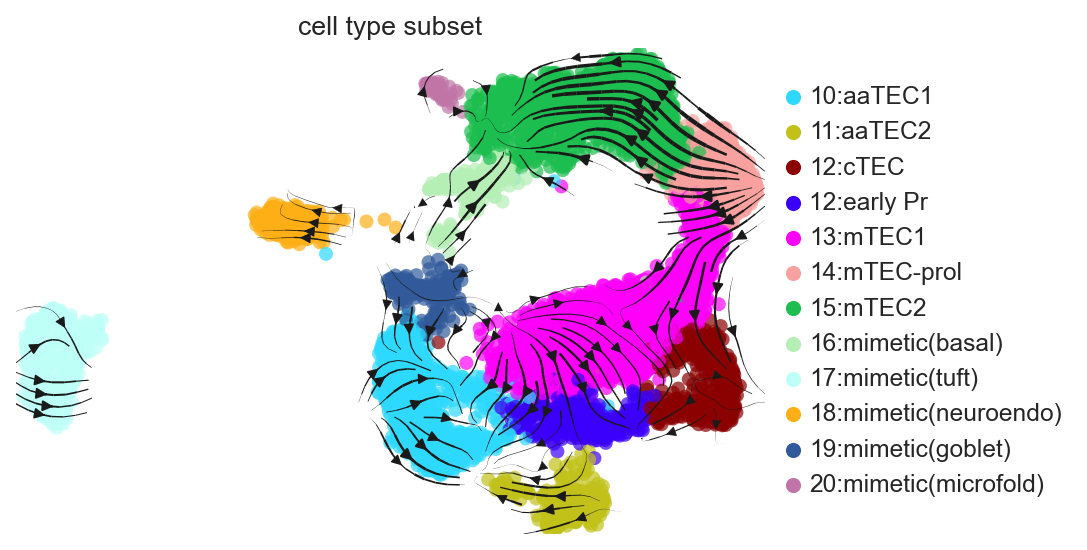

In [29]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0_loom, basis='umap', color=['cell_type_subset'],alpha=0.7, legend_loc='right')

In [30]:
TEC_d0_loom.obs['distinct'] = ''
TEC_d0_loom.obs['distinct'] = TEC_d0_loom.obs[['stage', 'cell_type_subset']].agg(' '.join, axis=1)

In [31]:
TEC_d0_loom.uns['distinct_colors'] = ['#2ED9FF', '#c1c119', '#8b0000', '#3B00FB',  '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                               '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB',  '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6']

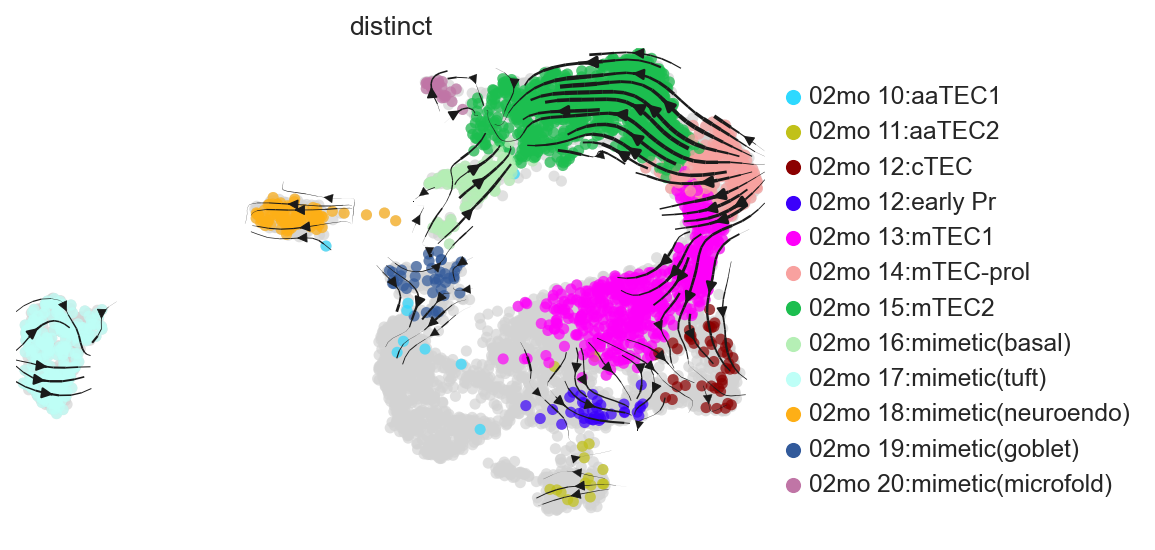

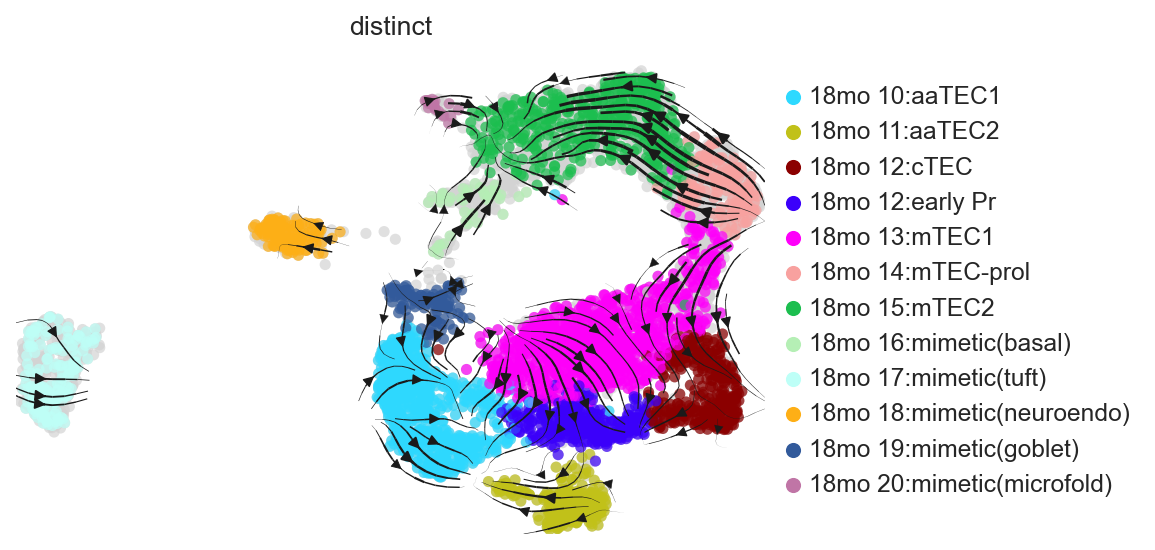

In [32]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0_loom, basis='umap', groups=['02mo 10:aaTEC1', '02mo 11:aaTEC2', '02mo 12:cTEC', '02mo 12:early Pr', '02mo 13:mTEC1', '02mo 14:mTEC-prol', '02mo 15:mTEC2', '02mo 16:mimetic(basal)', '02mo 17:mimetic(tuft)', '02mo 18:mimetic(neuroendo)', '02mo 19:mimetic(goblet)', '02mo 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7,  legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0_loom, basis='umap', groups=['18mo 10:aaTEC1', '18mo 11:aaTEC2', '18mo 12:cTEC', '18mo 12:early Pr', '18mo 13:mTEC1', '18mo 14:mTEC-prol', '18mo 15:mTEC2', '18mo 16:mimetic(basal)', '18mo 17:mimetic(tuft)', '18mo 18:mimetic(neuroendo)', '18mo 19:mimetic(goblet)', '18mo 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')

In [33]:
path_to_h5ad = '../output/anndata_io/Fig3f.h5ad'

In [34]:
TEC_d0_loom.write(path_to_h5ad)

### Only TECs - 18mo - all

In [35]:
TEC_d0_loom_18mo = TEC_d0_loom[TEC_d0_loom.obs['stage']=='18mo']

In [36]:
TEC_d0_loom_18mo.shape

(3791, 27006)

In [37]:
# Remove columns with all 0s
sc.pp.filter_genes(TEC_d0_loom_18mo, min_cells=1)

filtered out 1480 genes that are detected in less than 1 cells


In [38]:
sc.pp.highly_variable_genes(TEC_d0_loom_18mo, n_top_genes=3500, n_bins=20, flavor='seurat', inplace=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [39]:
rng = np.random.RandomState(42)
sc.tl.pca(TEC_d0_loom_18mo, n_comps=50, svd_solver='arpack', random_state=rng, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [40]:
sc.pp.neighbors(TEC_d0_loom_18mo, n_neighbors=15, use_rep='X_pca')
sc.tl.umap(TEC_d0_loom_18mo)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [41]:
TEC_d0_loom_18mo.uns['cell_type_subset_colors'] = ['#2ED9FF', '#c1c119', '#8b0000', '#3B00FB',  '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6']

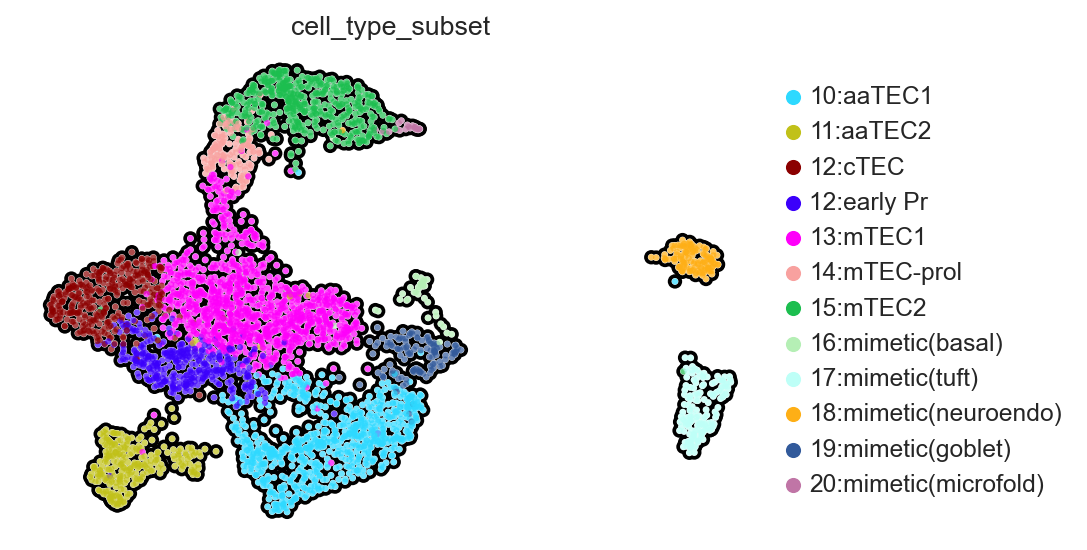

In [42]:
sc.pl.umap(TEC_d0_loom_18mo, color=['cell_type_subset'], 
                     color_map='Spectral_r',
                     use_raw=False, 
                     ncols=4, 
                     wspace = 0.3,
                     outline_width=[0.6, 0.05], 
                     frameon=False, 
                     add_outline=True)

In [43]:
scv.tl.velocity(TEC_d0_loom_18mo, mode='stochastic')

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [44]:
scv.tl.velocity_graph(TEC_d0_loom_18mo, n_jobs=6)

computing velocity graph (using 6/8 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


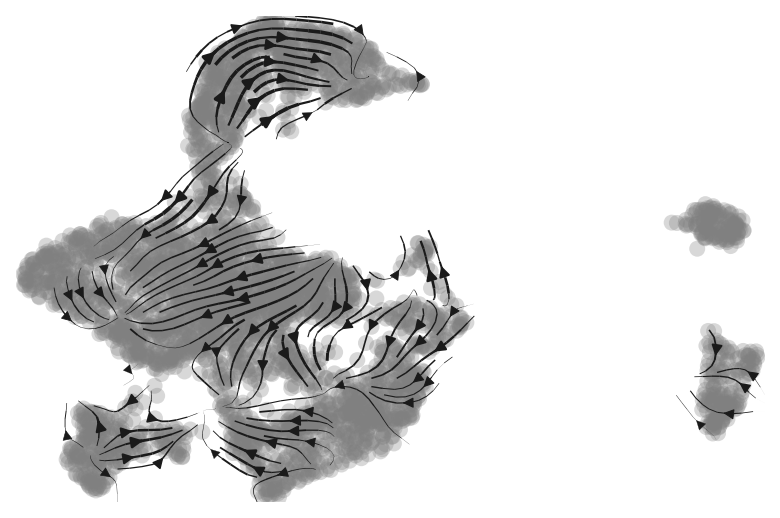

In [45]:
scv.pl.velocity_embedding_stream(TEC_d0_loom_18mo, basis='umap')

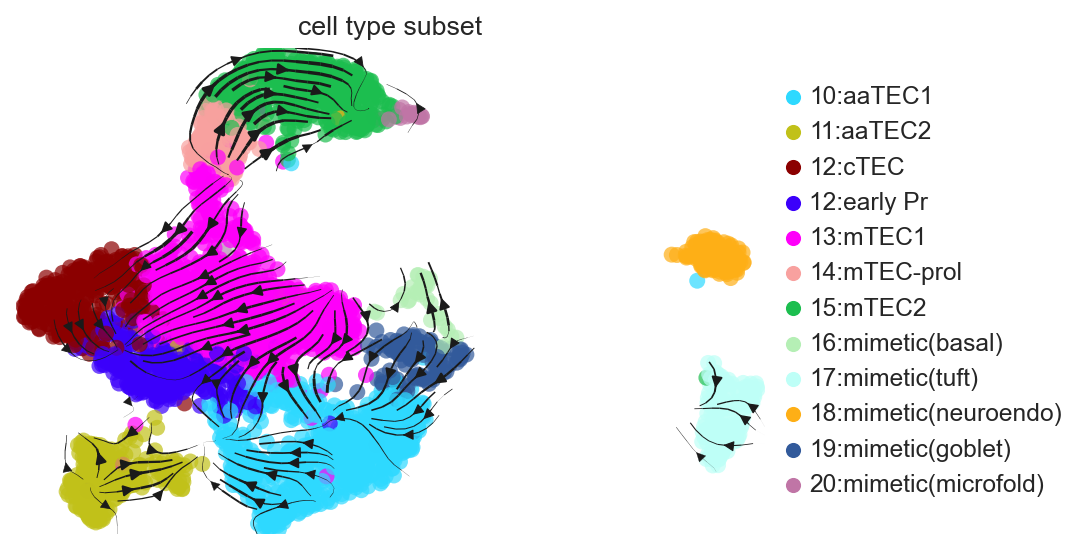

In [46]:
# also scv.pl.velocity_embedding_grid
scv.pl.velocity_embedding_stream(TEC_d0_loom_18mo, basis='umap', color=['cell_type_subset'],alpha=0.7, legend_loc='right')

In [47]:
path_to_h5ad = '../output/anndata_io/Vid2.h5ad'

In [48]:
TEC_d0_loom_18mo.write(path_to_h5ad)